In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import sys

if not ".." in sys.path:
    sys.path.append("..")

In [8]:
from tqdm import tqdm

import torch
from lit_modules.litmodels import LitMemNet, LitResNet50
from lit_modules.litdatamodules.lit_lamem import LitLaMemDataModule

In [9]:
RESNET_CHECKPOINT = "/home/soroush1/projects/def-kohitij/soroush1/pretrain-imagenet/resnet_lalem/lightning_logs/version_0/checkpoints/epoch=499-step=88000.ckpt"
MEMNET_CHECKPOINT = (
    "https://github.com/andrewrkeyes/Memnet-Pytorch-Model/raw/master/model.ckpt"
)

In [10]:
checkpoint = torch.utils.model_zoo.load_url(MEMNET_CHECKPOINT)

In [11]:
memnet = LitMemNet(checkpoint=checkpoint)
resnet = LitResNet50.load_from_checkpoint(RESNET_CHECKPOINT)

memnet.eval()
resnet.eval()

print("Completed")

Completed


In [13]:
root = "/home/soroush1/projects/def-kohitij/soroush1/pretrain-imagenet/data/LaMem/lamem_images/lamem"
dataset = LitLaMemDataModule(root=root, batch_size=64, num_workers=1)
dataset.setup("TEST")

test_loader = dataset.test_dataloader()

In [15]:
criterion = torch.nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
memnet.to(device)
resnet.to(device)

# No gradient computation needed for inference

losses = []
with torch.no_grad():
    for x, y in tqdm(test_loader):
        # Transfer input and target to the device
        x = x.to(device)
        y = y.to(
            device
        )  # Assuming 'y' is used for some evaluation, though not shown in this code

        # Get the outputs from both models
        memnet_output = torch.nn.functional.sigmoid(memnet(x))
        resnet_output = resnet(x)

        # Calculate the loss
        loss = criterion(resnet_output.squeeze(), memnet_output.squeeze())
        losses.append(loss.item())  # Store loss value

# Optionally, calculate the average loss
average_loss = sum(losses) / len(losses)
print(f"Completed. Average Loss: {average_loss}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [06:28<00:00,  2.48s/it]

Completed. Average Loss: 0.008820904326880244


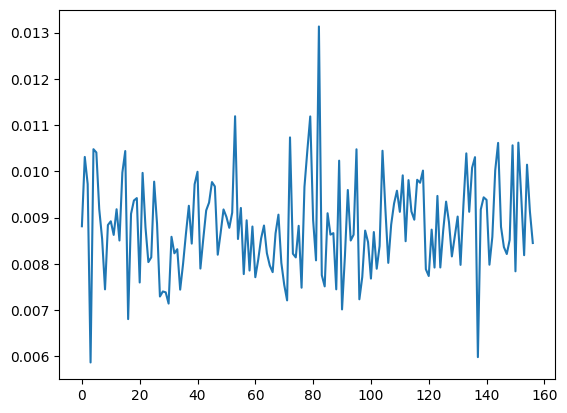

In [16]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
import gc

# Clear GPU cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Collect garbage
gc.collect()